# Assignment 1
## Deskriptiv analytik
### Thomas Nylund & Sonja Malmström

Information: We completed this assignment as a team and each part was done and tested by us both.  


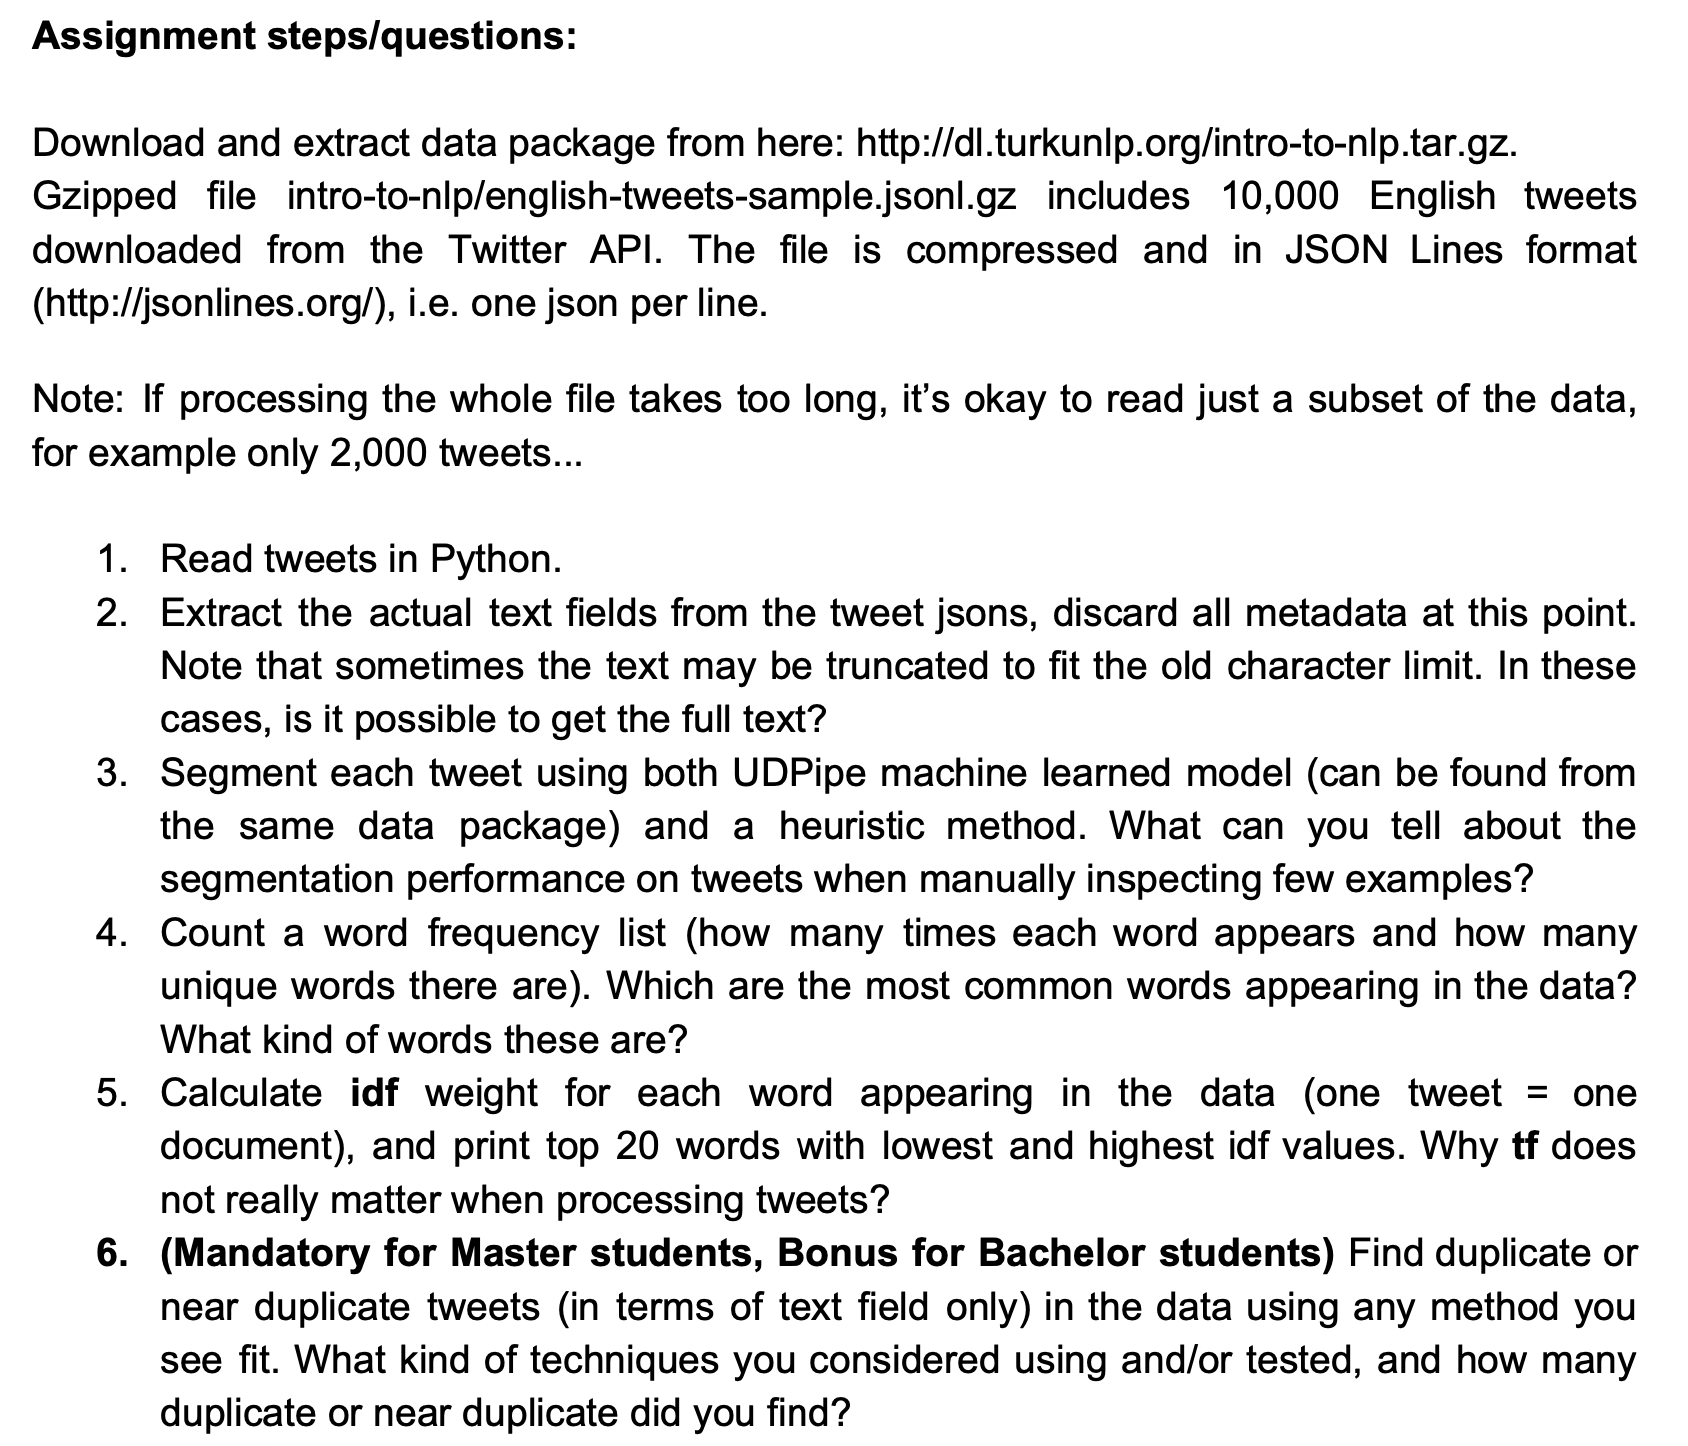

## 1. Read Tweets in Python

In [1]:
import jsonlines
import json

#with jsonlines.open('english-tweets-sample.jsonl') as reader:
#    for obj in reader.iter(type=dict, skip_invalid=True):
#        print(obj)

In [2]:
def load_jsonl(input_path) -> list:
    """
    Read list of objects from a JSON lines file.
    """
    data = []
    with open(input_path, 'r', encoding='utf-8') as f:
        for line in f:
            data.append(json.loads(line.rstrip('\n|\r')))
    print('Loaded {} records from {}'.format(len(data), input_path))
    return data

data = load_jsonl('english-tweets-sample.jsonl')

print (data[0].keys())

Loaded 10000 records from english-tweets-sample.jsonl
dict_keys(['created_at', 'id', 'id_str', 'text', 'display_text_range', 'source', 'truncated', 'in_reply_to_status_id', 'in_reply_to_status_id_str', 'in_reply_to_user_id', 'in_reply_to_user_id_str', 'in_reply_to_screen_name', 'user', 'geo', 'coordinates', 'place', 'contributors', 'is_quote_status', 'quote_count', 'reply_count', 'retweet_count', 'favorite_count', 'entities', 'extended_entities', 'favorited', 'retweeted', 'possibly_sensitive', 'filter_level', 'lang', 'timestamp_ms'])


### 2. Extract the actual text fields from the tweet jsons, discard all metadata at this point. Note that sometimes the text maybe truncated to fit the old character limit. In this cases, is it possible to get the full text?

In [3]:
tweets = []

for x in data:
    if x['truncated'] == True:
        tweets.append(x['extended_tweet']['full_text'])
    else:
        tweets.append(x['text'])
        
print(len(tweets))

10000


Comments: When looking at the keys of the tweet dictionaries we were able to identify the truncated key. From there we were able to find the extended_tweet and full_text keys that gave us access to the full text of those tweets that had been truncated. 

### 3. Segment each tweet using UDPipe machine learned model (can be found from the same data package) and a heuristic method. What can you tell on the segmentation performance on tweets when manually inspecting a few examples?

In [13]:
import ufal.udpipe as udpipe

model = udpipe.Model.load("./en.segmenter.udpipe")
pipeline = udpipe.Pipeline(model,"tokenize","none","none","horizontal") 
# horizontal: returns one sentence per line, with words separated by a single space

segmented_documents = []

for x in tweets:
    document = pipeline.process(x)
    segmented_documents.append(document)

In [14]:
for x in segmented_documents[:10]:
    print(x)

Check out my class in # GranblueFantasy !
https://t.co/pAvXn8diJr

Extending a big Thank
You to our Community Partner all over the world !
https://t.co/cu7on7g1si

Blueberry 🍨 https://t.co/2gzHAFWYJY

RT @ LILUZIVERT :
Bad day ☹️®️

@prologve_ @BTS_ARMY @BTS_twt I 'm Chim tho

i need a dog to cuddle with right now

RT : Country Inn countryinns # CampSprings 🏨 👉🚖 For Taxi 📞703-445-4450
https://t.co/lXdFUm4qUb

RT @ KimKardashian : DAY
10 - PENELOPE https://t.co/1z1cgzvZxh

RT @ CBCNews :
Winnipeggers wake up to the city 's coldest Christmas in 2 decades https://t.co/6R0nw7xDlL https://t.co/k5UuSf3kja

RT @ LuvTyagiTeam : 1id 1vote for 1 episode count hoga



In [15]:
import re

segmented_documents_v2 = []

for x in tweets:
    tokenized = re.sub(r'([.,!?]+)', r' \1', x) # replace . , ! ? with whitespace+character(s), '+' means one or more
    tokenized = re.sub(r"(n't)", r" \1", tokenized) # clitics
    segmented_documents_v2.append(tokenized)

In [16]:
for x in segmented_documents_v2[:10]:
    print(x)

Check out my class in #GranblueFantasy ! https://t .co/pAvXn8diJr
Extending a big Thank You to our Community Partner all over the world ! https://t .co/cu7on7g1si
Blueberry 🍨 https://t .co/2gzHAFWYJY
RT @LILUZIVERT: Bad day ☹️®️
@prologve_ @BTS_ARMY @BTS_twt I'm Chim tho
i need a dog to cuddle with right now
RT: Country Inn countryinns #CampSprings 🏨 👉🚖 For Taxi 📞703-445-4450 https://t .co/lXdFUm4qUb
RT @KimKardashian: DAY 10- PENELOPE https://t .co/1z1cgzvZxh
RT @CBCNews: Winnipeggers wake up to the city's coldest Christmas in 2 decades https://t .co/6R0nw7xDlL https://t .co/k5UuSf3kja
RT @LuvTyagiTeam: 1id 1vote for 1episode count hoga


Comments: When analyzing the regex segmented tweets it becomes quite clear that the quality of the tokenization isn't that good. The machine learned model does a much better job of tokenizing the tweets. The machine learned model recognizes links and emojis and special charachters,like ®️ and @, and toknizes them correctly. 

### 4. Count a word frequency list (how many times each word appears and how many unique words there are). Which are the most common words appearing in the data? What kind of words are these? 

In [17]:
from collections import Counter

token_counter = Counter()
for tweet in segmented_documents:
    tokens = tweet.split() # after segmenter, we can do whitespace splitting
    token_counter.update(tokens)

print("Most common tokens:", token_counter.most_common(20))
print("Vocabulary size:", len(token_counter))

Most common tokens: [('@', 7498), (':', 6644), ('RT', 5748), ('.', 3997), ('#', 3294), ('the', 3118), (',', 3062), ('to', 2745), ('a', 2336), ('I', 2060), ('and', 2036), ('…', 2030), ('you', 1894), ('of', 1613), ('for', 1529), ('is', 1496), ('in', 1456), ('!', 1241), ('-', 1225), ('on', 991)]
Vocabulary size: 36566


Comments: Not surprising, the most common words(tokens) are @, :, and RT which are twitter specific characters and are therefore over represented here. After that we can see a lot of stop words, which normally place high on word frequency lists. 

In [18]:
import nltk
nltk.download('stopwords') # download the stopwords dataset

from nltk.corpus import stopwords

filtered_tokens = []
punctuation_chars = '. , : ( ) ! ? " = & - ; ... “ \\ / //'.split() # list of punctuation symbols to ignore
for word, count in token_counter.most_common():
    if word.lower() in stopwords.words("english") or word in punctuation_chars:
        continue
    filtered_tokens.append((word, count))
    
print("Number of tokens:", len(filtered_tokens))
print("Tokens:", filtered_tokens[:20])
print(punctuation_chars)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\sonja\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Number of tokens: 36188
Tokens: [('@', 7498), ('RT', 5748), ('#', 3294), ('…', 2030), ("'s", 804), ('’s', 552), ("n't", 474), ('Christmas', 468), ('like', 407), ('n’t', 404), ('amp', 382), ('one', 330), ('people', 301), ('love', 290), ("'", 289), ('get', 267), ('2017', 266), ('1', 246), ('year', 241), ('”', 233)]
['.', ',', ':', '(', ')', '!', '?', '"', '=', '&', '-', ';', '...', '“', '\\', '/', '//']


Comments: Now when we remove stop words we can see some more interesting words. Christmas is one of the most frequent words in the provided dataset which would indicate that these tweets are probably from late November or December and that people like talking tweeting about Christmas. One thing that we also noticed was that n't and n’t appear separately because they use a different quotation mark, this is something that we would try and fix if we were going to do more in depth analysis on the tweets in this dataset.

### 5. Calculate idf weight for each word appearing in the data (one tweet = one document), and print 20 words with the heighest and the lowest idf value. Why does tf not really matter when processing tweets?

In [19]:
all_tokens_without_punctuation = []

punctuation_chars = '. , : ( ) ! ? " = & - ; ... “ \\'.split()

for word, count in token_counter.items():
    if word in punctuation_chars:
        continue
    all_tokens_without_punctuation.append((word, 0))

In [20]:
import math

counted_tokens = []

for word, count in all_tokens_without_punctuation:
    count = 0
    for tweet in segmented_documents:
        if word in tweet:
            if len(word) > 1: # if word length is less than 1 we want to run it through some filters.
                if not re.compile(r'(?i)(htt|:\/|:\/\/)').search(word): # ignoring tokens that are links or have parts of links(://, htt, :/)
                    count += 1
            else:
                if word == "@" or word == "#": # including # and @
                    count += 1
                else:
                    if word.lower() == "i" or word.lower() == "u" or word.lower() == "a":
                        if re.compile(r'(?i)(?<![a-z])(i|a|u)(?![a-z])').search(tweet): # standalone single characters i, u, and a
                            count += 1
                    elif re.compile(r'(?i)(?<= )[a-z](?= )').search(word): # excluding any standalone single characters that have no meaning
                        count += 1 
    if count > 0: # due to peoples lackluster grammar on twitter there are many tokens in the tokenlist that are filtered out in the above loop,
        counted_tokens.append((word, count, math.log(len(segmented_documents)/count))) # which is why they might not get any counts and why we want to exclude them from the final list. 
    
counted_tokens_bottom_20 = sorted(counted_tokens, key=lambda token: token[1])
counted_tokens_top_20 = sorted(counted_tokens, key=lambda token: token[1], reverse=True)   
print("Bottom 20: ", counted_tokens_bottom_20[:20])
print("\nTop 20: ", counted_tokens_top_20[:20])

Bottom 20:  [('Extending', 1, 9.210340371976184), ('Partner', 1, 9.210340371976184), ('Blueberry', 1, 9.210340371976184), ('@prologve_', 1, 9.210340371976184), ('@BTS_ARMY', 1, 9.210340371976184), ('Chim', 1, 9.210340371976184), ('countryinns', 1, 9.210340371976184), ('CampSprings', 1, 9.210340371976184), ('PENELOPE', 1, 9.210340371976184), ('CBCNews', 1, 9.210340371976184), ('Winnipeggers', 1, 9.210340371976184), ('coldest', 1, 9.210340371976184), ('1vote', 1, 9.210340371976184), ('/#', 1, 9.210340371976184), ('dianacooper55', 1, 9.210340371976184), ('PulaskiFootball', 1, 9.210340371976184), ('Ree_Tumii', 1, 9.210340371976184), ('UTRUST_Official', 1, 9.210340371976184), ('UTRUST', 1, 9.210340371976184), ('Bitcointalk', 1, 9.210340371976184)]

Top 20:  [('@', 7288, 0.3163559330363884), ('in', 5833, 0.5390536452225451), ('RT', 5689, 0.5640506072255353), ('th', 5318, 0.6314878001732176), ('ht', 5305, 0.6339353209280992), ('an', 5061, 0.6810210007621048), ('ps', 5028, 0.6875628022660447),

Comments: We think term frequency(tf) is not important in this case because of the following reasons:
- All tweets have different authors. 
- There are many words/characters that are over represented due to their specific usage on the twitter platform. 
- Tweets are also full of slang and mispellings which explodes the token count.